# 2022 영화

In [1]:
import pandas as pd
import numpy as np
from kiwipiepy import Kiwi
import copy
import re
from kiwipiepy.utils import Stopwords
import nltk

from wordcloud import WordCloud # 워드클라우드 제작 라이브러리
import pandas as pd # 데이터 프레임 라이브러리
import numpy as np # 행렬 라이브러리
import matplotlib.pyplot as plt # 워드클라우드 시각화 라이브러리
%matplotlib inline
import konlpy

In [2]:
df = pd.read_csv('./data_movie/2022년 개봉작.csv', encoding='utf-8')

# postdate, body, description, title 칼럼만 사용 
df = df[['postdate', 'body', 'description', 'title']]
df.head()

,postdate,body,description,title
0,20221226,"*이번주 추천작은 올해 영화 베스트 10, 올해 넷플릭스 베스트 10으로 대체합니다...","*이번주 추천작은 올해 영화 베스트 10, 올해 넷플릭스 베스트 10으로 대체합니다...",2022년 올해의 영화 베스트 10 (국내 개봉작)
1,20221229,2022년에 들어서야 전 세계 극장가가 원래대로의 모양새를 갖추기 시작했다. 개봉이...,"아쉽게 놓친 <b>2022년 개봉작<\/b> 리스트를 정리한 뒤, 그 영화들을 관람...",놓쳤다면 꼭 보세요! 2022년 개봉작 중 안 보면 아쉬울 영화들
2,20221223,2022년 프라이빗 영화 대상 포스트 코로나 시대를 맞아 영화시장은 활기를 되찾는 ...,영화시장의 부응을 바라는 마음에서 2022년 국내 개봉작 중 최우수 작품을 가리는 ...,2022년 국내 개봉작 최우수 작품은? 프라이빗 영화 대상
3,20221230,1년이 끝나감에 따라 이번 연도에 보게 된 영화들을 한 번 총정리 해보고자 한다. ...,보자 <b>2022년 개봉작<\/b> TOP 10 TOP 10 공조 2 : 인터내셔...,[2022년 영화 연말 결산 개봉작 TOP10]
4,20230217,"지난 8일 개봉하여 평단의 호평을 받으며, 다양성 영화에도 불구 5만명이상의 관객을...","여성서사 중심의 한국영화 순위 (2021년, <b>2022년 개봉작<\/b> 기준)...","여성서사 중심의 한국영화 순위 (2021년, 2022년 개봉작 기준)"


## 1. 전처리

In [3]:
# 전처리할 칼럼들
columns = ['body', 'description', 'title']

# 중복 제거
df.drop_duplicates(subset=columns, inplace=True)

for column in columns:
    # 정규표현식 - 한글, 숫자, 영어 및 공백 이외의 문자 제거
    df[column] = df[column].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]", "", regex=True)
    # 앞뒤 공백 제거
    df[column] = df[column].str.strip()
    # 여러 개의 공백을 하나의 공백으로 변경
    df[column] = df[column].str.replace(' +', " ", regex=True)

# 공백만 있는 칼럼을 NaN으로 변경 후 제거
df[columns] = df[columns].replace('', np.nan)
df.dropna(subset=columns, how='any', inplace=True)

In [4]:
from kiwipiepy import Kiwi

# Kiwi 초기화
kiwi = Kiwi()

# 불용어 리스트 정의 및 파일 로드
additional_stopwords = [
'개봉작', '2022년', '영화', '개봉', '감독', '작품', '수익', '관객', '배우', '출연', '박스오피스',
'이야기', '관람', '한국', '흥행', '누적', '기록', '국내', '주연', '예정', '액션', '생각', '극장',
'시리즈', '상영', '연출', '사람', '연기', '시작', '드라마', '대비', '소개', '출처', '순위', '올해',
'정보', '공개', '개봉일', '최고', '신규', '추천', '후기', '출연진', '주차', '신작', '제목', '연속',
'리뷰', '순위', '상영', '줄거리', '평점', '결산', '정리', '돌파', '작품', '주말', '데히', '사랑',
'세계', '보이', '기대', '내용', '이후', '제작비', '가족', '장르', '모습', '영화제', '정도', '장면',
'주인공', '때문', '상황', '이름', '이미지', '기준', '구글', '이후', '원작', '오늘', '기대작', '주말',
'프로필', '예고편', '거리', '베스트', '시간표', '성적', '스포', '등극', '필모그래피', '최신', '역대', '결말',
'대하', '상영관', '스토리', '등장', '수상', '예매', '선정', '예측'
]

# 불용어 텍스트 파일에서 불용어 읽기
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords_list = file.read().splitlines()
    return stopwords_list

# 파일에서 불용어 목록 로드
stopwords_file_path = 'stopwords.txt'
file_stopwords = load_stopwords(stopwords_file_path)

# 불용어 리스트 결합
all_stopwords = set(additional_stopwords + file_stopwords)

In [5]:
# 불용어 제거 함수 정의
def remove_stopwords(text, stopwords):
    tokens = kiwi.tokenize(text)
    filtered_tokens = [token.form for token in tokens if token.form not in stopwords]
    return ' '.join(filtered_tokens)

# 전처리 함수 정의
def preprocess_korean(text, analyzer=kiwi, stopwords=all_stopwords):
    my_text = copy.copy(text)
    my_text = my_text.replace('\n', ' ') # (1) 줄바꿈 문자 제거
    my_text = analyzer.space(my_text) # (2) 띄어쓰기 교정
    sents = analyzer.split_into_sents(my_text) # (3) 문장 토큰화
    p = re.compile('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]')
    all_result = []
    for sent in sents:
        token_result = remove_stopwords(sent.text, stopwords) # (4) 형태소 분석 및 불용어 제거
        token_result = p.sub(' ', token_result) # (5) 특수 문자 제거 (=한글을 제외한 문자 제거)
        all_result.append(token_result) # (6) 형태소 분석한 결과를 다시 join
    
    all_result = ' '.join(all_result) # (7) 모든 문장을 하나의 string으로 join

    return all_result

# 품사(명사, 동사, 형용사, 부사) 추출 함수 정의
def wordclass_korean(my_str, kiwi=kiwi):
    result = []
    tokens = kiwi.tokenize(my_str, normalize_coda=True)
    for token in tokens:
        if token.tag in ['NNG', 'NNP', 'NNB']:  # 명사 태그만 추출
            result.append(token.form)
    result = ' '.join(result)
    return result

In [6]:
%%time
# 전처리 함수 적용
for column in columns:
    preprocessed_column = 'preprocessed_' + column 
    df[preprocessed_column] = df[column].apply(lambda x: preprocess_korean(x))

# 품사 추출 함수 적용
preprocessed_columns = ['preprocessed_body', 'preprocessed_title', 'preprocessed_description']
for column in preprocessed_columns:
    df[column] = df[column].apply(wordclass_korean)

df.head()

CPU times: total: 1min 6s
Wall time: 4min 2s


,postdate,body,description,title,preprocessed_body,preprocessed_description,preprocessed_title
0,20221226,이번주 추천작은 올해 영화 베스트 10 올해 넷플릭스 베스트 10으로 대체합니다 2...,이번주 추천작은 올해 영화 베스트 10 올해 넷플릭스 베스트 10으로 대체합니다 b...,2022년 올해의 영화 베스트 10 국내 개봉작,추천작 넷플릭스 대체 의미 위주 머릿속 반사 목록 지난달 포함 오랜만 상위 연말 마...,추천작 넷플릭스 대체 의미 것,
1,20221229,2022년에 들어서야 전 세계 극장가가 원래대로의 모양새를 갖추기 시작했다 개봉이 ...,아쉽게 놓친 b2022년 개봉작b 리스트를 정리한 뒤 그 영화들을 관람하며 연말 연...,놓쳤다면 꼭 보세요 2022년 개봉작 중 안 보면 아쉬울 영화들,전 극장가 대로 모양새 미 다양 리스트 뒤 연말 연초 굿바이 방법 사랑 때 최악 사...,리스트 뒤 연말 연초 굿바이 방법 사랑 때 최악 사랑 때 최악,중
2,20221223,2022년 프라이빗 영화 대상 포스트 코로나 시대를 맞아 영화시장은 활기를 되찾는 ...,영화시장의 부응을 바라는 마음에서 2022년 국내 개봉작 중 최우수 작품을 가리는 ...,2022년 국내 개봉작 최우수 작품은 프라이빗 영화 대상,프라이 빗 대상 포스트 코로나 시대 시장 활기 듯 침체기 채 어려움 뿐 라 적 불황...,시장 부응 마음 중 우수 프라이 빗 마지막 중 아바타 물 길 부실 스토리텔링 비판 의견,우수 은 프라이 빗 대상
3,20221230,1년이 끝나감에 따라 이번 연도에 보게 된 영화들을 한 번 총정리 해보고자 한다 여...,보자 b2022년 개봉작b TOP 10 TOP 10 공조 2 인터내셔날 기대 이상으...,2022년 영화 연말 결산 개봉작 TOP10,연 번 보 도 은 연도 뿐 라 과거 중 인상 도 존재 중 연도 대표 번 공조 인터내...,보 공조 인터내셔날 캐릭터 기억 전작 공중 목적,연말
4,20230217,지난 8일 개봉하여 평단의 호평을 받으며 다양성 영화에도 불구 5만명이상의 관객을 ...,여성서사 중심의 한국영화 순위 2021년 b2022년 개봉작b 기준 순위선정 기준 ...,여성서사 중심의 한국영화 순위 2021년 2022년 개봉작 기준,평단 호평 다양 불구 명 소희 가학 피 학 침묵 방관 주제 여성 코로나 본격 여성 ...,여성 서사 중심 명 중 여성 단독 남성 공동 여성 역할,여성 서사 중심


In [7]:
# 전처리한 결과 csv로 저장 
df.to_csv('22영화_전처리.csv', index=False, encoding='utf-8-sig')

## 2. 단어 빈도 계산

In [8]:
# 단어 빈도 계산 및 상위 단어 추출 
def explode_and_count(df, column):
    exploded = df[column].str.split().explode()  # 문자열을 단어 단위로 나누어 행으로 펼침
    word_counts = exploded.value_counts().reset_index()  # 단어 빈도 계산
    word_counts.columns = ['word', 'count']  # 컬럼명 설정
    return word_counts

### [preprocessed_body]

In [9]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_body']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [10]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_body = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_body = all_words_body[all_words_body['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_body.head(30)
top_30_words

,word,count
3557,달러,1610
8658,북미,929
15121,월드,779
8937,블랙,741
3055,넷플릭스,734
1869,극장판,725
23229,해외,722
12952,애니메이션,702
4557,디즈니,593
12396,아바타,540


### [preprocessed_description]

In [11]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_description']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [12]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_description = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_description = all_words_description[all_words_description['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_description.head(30)
top_30_words

,word,count
503,넷플릭스,65
2230,외국,47
1890,아바타,44
583,달러,41
1218,범죄도시,41
874,마블,41
2281,월드,36
1966,애니메이션,35
323,극장가,34
3012,추석,33


### [preprocessed_title]

In [13]:
# 각 칼럼에 대해 단어 빈도 계산
word_counts_list = []
for column in ['preprocessed_title']:
    word_counts = explode_and_count(df, column)
    word_counts_list.append(word_counts)

In [14]:
# 모든 칼럼의 단어 빈도 합산 및 정렬
all_words_title = pd.concat(word_counts_list).groupby('word').sum().reset_index().sort_values(by='count', ascending=False)

# 한 글자 단어 제외
all_words_title = all_words_title[all_words_title['word'].str.len() > 1]

# 상위 30개 단어 출력
top_30_words = all_words_title.head(30)
top_30_words

,word,count
194,넷플릭스,60
631,북미,50
313,동원,36
891,아바타,24
422,마블,23
1357,추석,22
653,블랙,21
584,범죄도시,17
925,애니메이션,16
1464,트리,16


## 3. 워드 클라우드

참고 사이트: https://serendipity77.tistory.com/entry/영화동감-영화동감-댓글-리뷰-워드-클라우드wordcloud로-만들어보기파이썬-Python 

[엑셀 자동화로 칼퇴하는 김대리의 고군분투기:티스토리]

In [15]:
font_path='C:\\Windows\\Fonts\\malgun.ttf'

### [body WordCloud]

In [30]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_body.set_index('word').to_dict()['count']
dic_word

{'달러': 1610,
 '북미': 929,
 '월드': 779,
 '블랙': 741,
 '넷플릭스': 734,
 '극장판': 725,
 '해외': 722,
 '애니메이션': 702,
 '디즈니': 593,
 '아바타': 540,
 '스릴러': 513,
 '범죄도시': 507,
 '미국': 490,
 '캐릭터': 488,
 '매버릭': 484,
 '사건': 479,
 '스파이더맨': 472,
 '마블': 469,
 '공포': 464,
 '제작': 456,
 '범죄': 454,
 '마지막': 450,
 '코미디': 442,
 '배트맨': 434,
 '일본': 434,
 '오브': 423,
 '평가': 415,
 '극장가': 411,
 '진행': 405,
 '기간': 405,
 '친구': 398,
 '성공': 397,
 '타임': 393,
 '버스': 392,
 '비밀': 386,
 '와이드': 384,
 '예상': 381,
 '기자': 380,
 '남자': 377,
 '닥터': 373,
 '차지': 371,
 '팬서': 364,
 '후보': 356,
 '가능': 354,
 '게임': 349,
 '스트레인지': 346,
 '시네마': 338,
 '웨이': 331,
 '부분': 330,
 '영화관': 329,
 '다양': 327,
 '엄마': 327,
 '가지': 326,
 '코로나': 320,
 '인생': 319,
 '로맨스': 316,
 '인하': 315,
 '결심': 314,
 '국제': 314,
 '촬영': 313,
 '멀티': 313,
 '등급': 310,
 '느낌': 310,
 '독립': 310,
 '인물': 308,
 '개인': 308,
 '토르': 305,
 '마음': 302,
 '공조': 301,
 '추석': 295,
 '기억': 294,
 '재미': 294,
 '포스터': 292,
 '크루즈': 291,
 '전체': 290,
 '죽음': 289,
 '외계인': 285,
 '해적': 285,
 '포에버': 281,
 '세상': 280,
 '증감': 

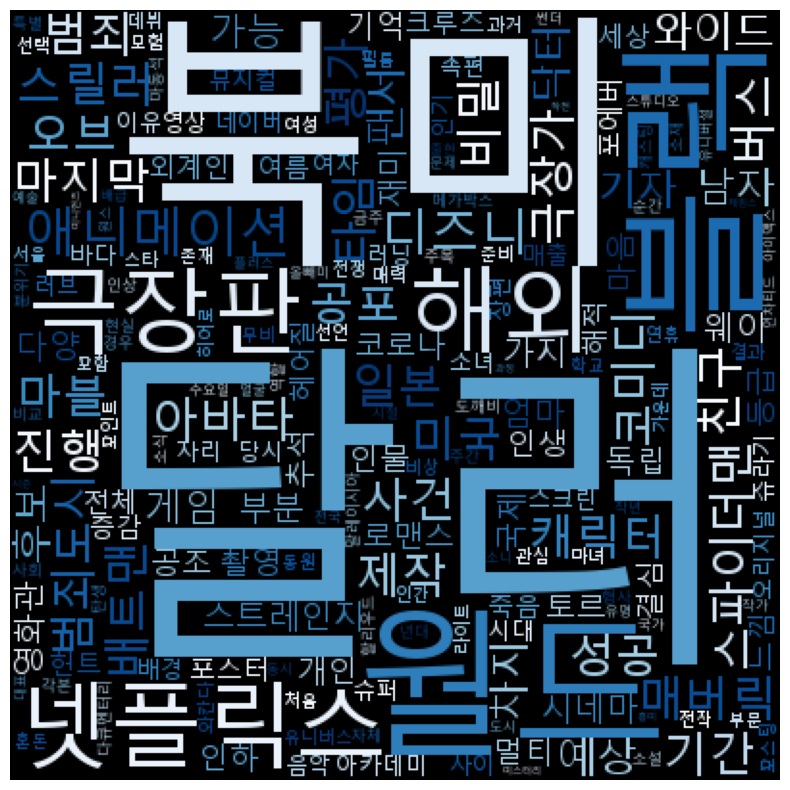

In [31]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')
               ## 'Blues': 파란색 그라데이션
               ## 'BuGn': 청록색
               ## 'BuPu': 진보라 ~ 연한 파란색 ~ 하얀색 
               ## 'GnBu': 진파랑 ~ 연한 초록색 ~ 하얀색
               ## 'Greys': 검은색 ~ 회색 ~ 하얀색
               ## 'OrRd': 진빨강 ~ 연한 오렌지 ~ 하얀색
               ## 'Pastel1': 파스텔 색
               ## 'Pastel2': 파스텔 색
               ## 'PuBu': 진파랑 ~ 핑크 ~ 하얀색
               ## 'PuRd': 자주 ~ 핑크 ~ 하얀색
               ## 'Purples': 보라색
               ## 'RdPu': 보라 ~ 자주 ~ 핑크
               ## 'Reds': 빨강
               ## 'Wistia': 주황 ~ 형광 노랑
               ## 'YlGnBr': 파랑 ~ 초록 ~ 노랑


img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

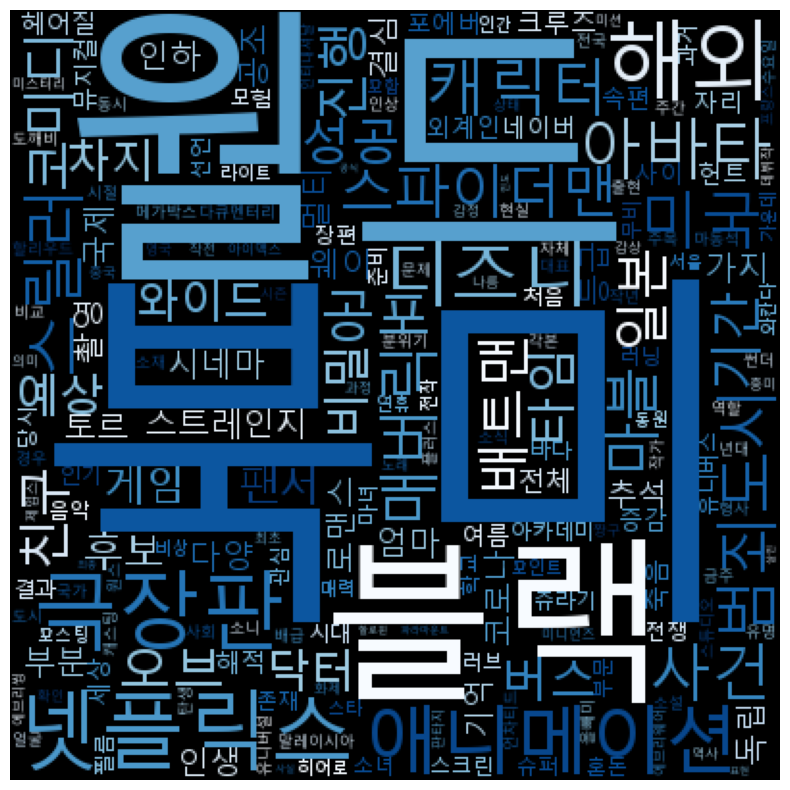

In [32]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'특별', '선택', '범죄', '데뷔', '가능', '이유', '예술', '마지막', '배경',
             '포스터', '개인', '여자', '여성', '평가', '영상', '남자', '오리지널', '느낌',
             '재미', '인물', '제작', '매출', '마음', '기자', '순간', '극장가', '영화관',
             '마음', '달러'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [description WordCloud]

In [21]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_description.set_index('word').to_dict()['count']
dic_word

{'넷플릭스': 65,
 '외국': 47,
 '아바타': 44,
 '달러': 41,
 '범죄도시': 41,
 '마블': 41,
 '월드': 36,
 '애니메이션': 35,
 '극장가': 34,
 '추석': 33,
 '북미': 32,
 '미국': 30,
 '블랙': 30,
 '해적': 30,
 '영화관': 29,
 '매버릭': 29,
 '코로나': 29,
 '여름': 28,
 '닥터': 27,
 '공포': 27,
 '극장판': 26,
 '결심': 26,
 '배트맨': 26,
 '디즈니': 25,
 '외계인': 25,
 '헤어질': 25,
 '스트레인지': 24,
 '촬영': 23,
 '일본': 23,
 '공조': 22,
 '오브': 22,
 '스릴러': 21,
 '아카데미': 21,
 '등급': 21,
 '국제': 21,
 '도깨비': 21,
 '버스': 21,
 '가운데': 21,
 '상반기': 20,
 '개인': 20,
 '포스터': 20,
 '마지막': 20,
 '깃발': 20,
 '연휴': 19,
 '후보': 19,
 '스파이더맨': 18,
 '타임': 18,
 '토르': 18,
 '경관': 18,
 '멀티': 17,
 '소설': 17,
 '관람료': 17,
 '올빼미': 17,
 '속편': 17,
 '포함': 17,
 '로맨스': 17,
 '쥬라기': 17,
 '회원': 17,
 '동감': 17,
 '기간': 17,
 '단독': 17,
 '아이맥스': 17,
 '웨이': 16,
 '할인': 16,
 '헌트': 16,
 '포스팅': 16,
 '처음': 16,
 '표시': 16,
 '제작': 16,
 '코미디': 16,
 '러브': 16,
 '소식': 16,
 '금일': 15,
 '당시': 15,
 '가지': 15,
 '준비': 15,
 '복지': 15,
 '오프닝': 15,
 '안내': 15,
 '범죄': 14,
 '혼돈': 14,
 '수입': 14,
 '네이버': 14,
 '인기': 14,
 '장애인': 14,
 '러닝': 14,
 '시즌': 14,
 

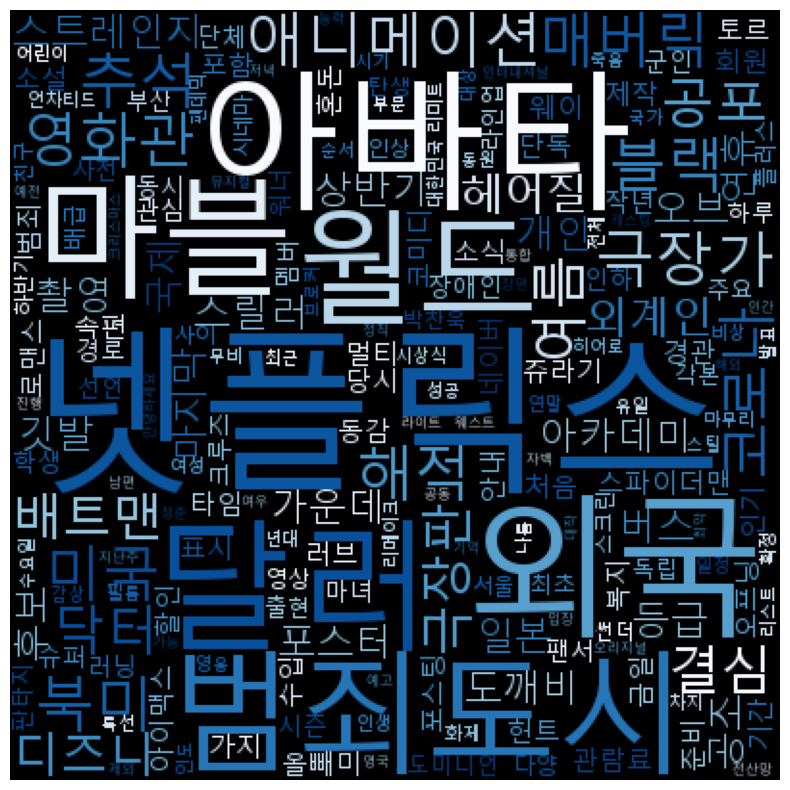

In [23]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

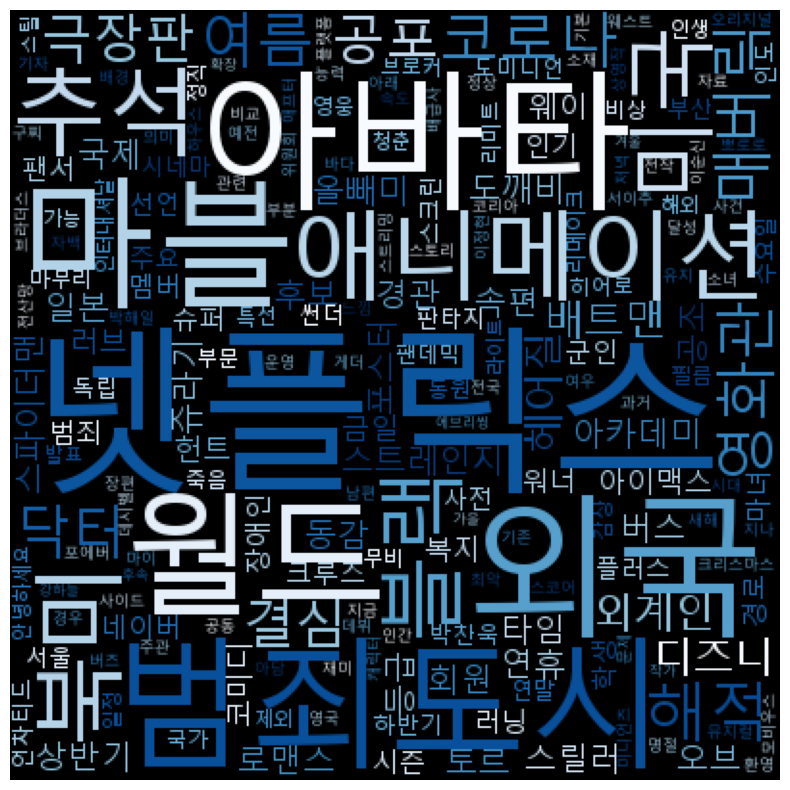

In [29]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'년대', '카운트', '마지막', '어린이', '소설', '촬영', '깃발', '동시', '관심',
             '혼돈', '순서', '인상', '라인업', '시기', '탄생', '화제', '포스팅', '처음',
             '극장가', '하루', '제작', '영상', '출현', '가운데', '당시', '친구', '배급',
             '대한민국', '작년', '안내', '최근', '관람료', '나름', '확정', '인하', '리스트',
             '단독', '수입', '대상', '개인', '오프닝', '주목', '할인', '캐스팅', '단체',
             '지난주', '다양', '달러', '시상식', '사이', '매출액', '사이', '포함', '최초',
             '전체', '방영', '입장', '기간', '진행', '대작', '준비', '예고', '여성',
             '통합', '기억', '차지', '각본', '가지', '표시', '마지막', '멀티', '당시', '시상식',
             '성공', '소식', '유일', '하루'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

## [title WordCloud]

In [33]:
## 데이터 프레임을 딕셔너리 형태로 변환해야 함

dic_word = all_words_title.set_index('word').to_dict()['count']
dic_word

{'넷플릭스': 60,
 '북미': 50,
 '동원': 36,
 '아바타': 24,
 '마블': 23,
 '추석': 22,
 '블랙': 21,
 '범죄도시': 17,
 '애니메이션': 16,
 '트리': 16,
 '공조': 16,
 '씨네아': 16,
 '매버릭': 16,
 '스트레인지': 15,
 '닥터': 15,
 '팬서': 13,
 '특선': 13,
 '디즈니': 13,
 '외계인': 12,
 '배트맨': 12,
 '라인업': 12,
 '월드': 12,
 '도깨비': 12,
 '연말': 12,
 '해적': 12,
 '깃발': 11,
 '영상': 11,
 '상반기': 11,
 '올빼미': 11,
 '이주': 10,
 '크루즈': 10,
 '스릴러': 10,
 '공포': 10,
 '와칸다': 10,
 '포에버': 10,
 '일기': 10,
 '시네마': 9,
 '극장판': 9,
 '헌트': 9,
 '연휴': 9,
 '쿠키': 9,
 '선언': 9,
 '오브': 9,
 '동감': 9,
 '비밀': 9,
 '비상': 9,
 '로맨스': 8,
 '인터내셔날': 8,
 '차기': 8,
 '주요': 8,
 '주간': 8,
 '독립': 8,
 '마녀': 8,
 '신비한': 8,
 '근황': 8,
 '달러': 7,
 '극장가': 7,
 '정상': 7,
 '편성표': 7,
 '마지막': 7,
 '쥬라기': 7,
 '공유': 7,
 '덤블도어의': 7,
 '손익': 7,
 '일본': 7,
 '범죄': 7,
 '출현': 7,
 '하반기': 7,
 '동물들과': 7,
 '파묘': 7,
 '혼돈': 7,
 '두기': 7,
 '분기점': 7,
 '해외': 6,
 '등장인물': 6,
 '달성': 6,
 '평창': 6,
 '토르': 6,
 '여름': 6,
 '멀티': 6,
 '플러스': 6,
 '인생': 6,
 '순서': 6,
 '속편': 6,
 '버스': 6,
 '인기': 6,
 '겨울': 6,
 '결심': 6,
 '자백': 6,
 '외국': 6,
 '히어로': 6,
 '예고': 6

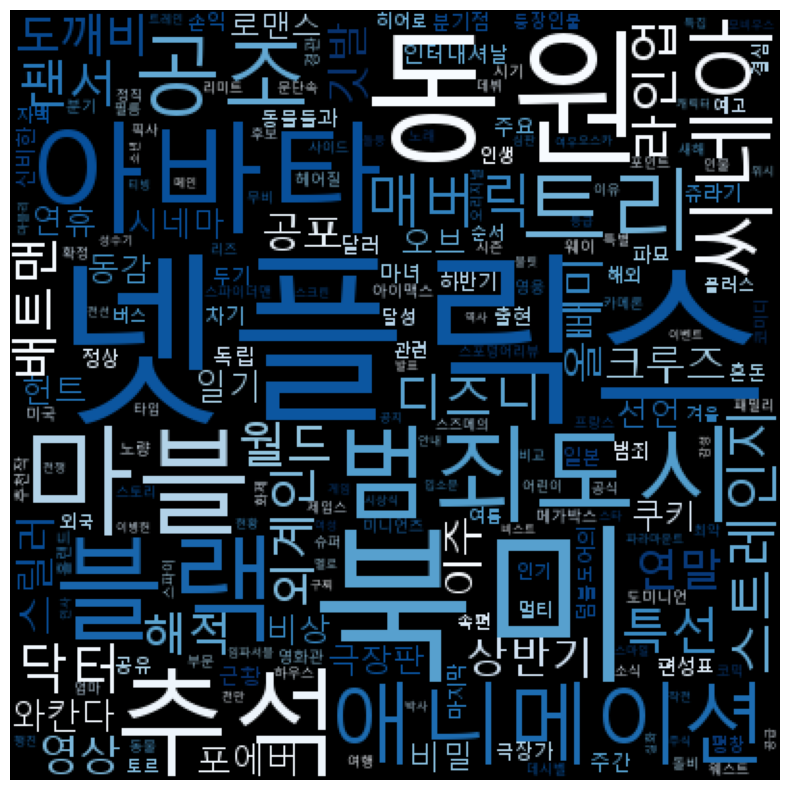

In [35]:
## colormap 참고 사이트: https://wonhwa.tistory.com/20

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues')

img_wordcloud = wc.generate_from_frequencies(dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기

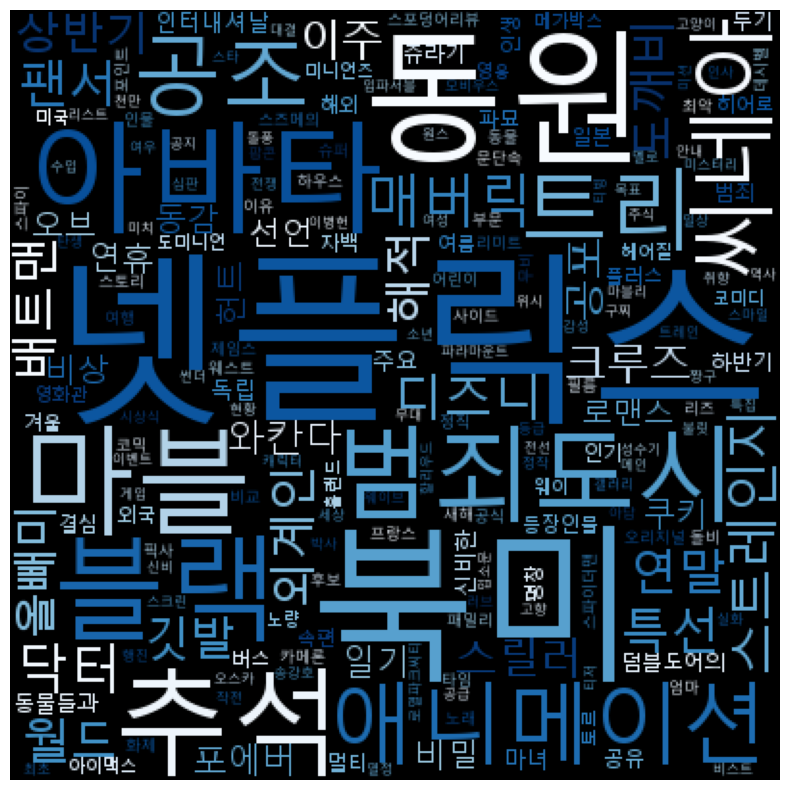

In [37]:
## 불용어 설정
## 참고 사이트: https://coding-yesung.tistory.com/201

from wordcloud import STOPWORDS

# 불용어 리스트
stopwords = {'손익', '분기', '확정', '정상', '추천작', '영상', '차기', '경관', '분기점', '시기',
             '데뷔', '순서', '시즌', '관련', '발표', '혼돈', '편성표', '극장가', '주간',
             '마지막', '달성', '관련', '발표', '특별', '극장판', '소식', '예고', '라인업',
             '달러', '근황', '시네마', '출현'}

# 불용어 제거
filtered_dic_word = {word: count for word, count in dic_word.items() if word not in stopwords}

wc = WordCloud(random_state = 123, font_path = font_path, width = 400,
               height = 400, background_color = 'black',
               colormap = 'Blues',
               stopwords = STOPWORDS)

img_wordcloud = wc.generate_from_frequencies(filtered_dic_word)

plt.figure(figsize = (10, 10)) # 크기 지정하기
plt.axis('off') # 축 없애기
plt.imshow(img_wordcloud) # 결과 보여주기